In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!mkdir -p hateful_memes
!unzip -q gdrive/MyDrive/data.zip -d /content/hateful_memes/

!pip install --quiet \
    transformers torch torchvision tqdm scikit-learn matplotlib seaborn wandb \
    pillow opencv-python ftfy regex git+https://github.com/openai/CLIP.git \
    albumentations


Mounted at /content/gdrive
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00


In [ ]:
import os, json, random, re
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score, precision_recall_curve
)
from tqdm.notebook import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

MODEL_TYPE = "BLIP"

if MODEL_TYPE == "CLIP":
    import clip
    backbone, _ = clip.load("ViT-B/32", device=device)
    def extract_image_feats(imgs):
        return backbone.encode_image(imgs).float()
    def extract_text_feats(tokens):
        return backbone.encode_text(tokens).float()
    tokenize_fn = lambda texts: clip.tokenize(texts)

elif MODEL_TYPE == "BLIP":
    from transformers import BlipProcessor, BlipModel
    processor = BlipProcessor.from_pretrained(
        "Salesforce/blip-image-captioning-base",
        use_fast=True
    )
    backbone = BlipModel.from_pretrained(
        "Salesforce/blip-image-captioning-base"
    ).to(device)
    def extract_image_feats(imgs):
        pix = processor(
            images=[t.cpu().permute(1,2,0).numpy() for t in imgs],
            return_tensors="pt"
        ).pixel_values.to(device)
        return backbone.get_image_features(pixel_values=pix).float()
    def extract_text_feats(texts):
        enc = processor(
            text=texts, return_tensors="pt", padding=True
        ).to(device)
        return backbone.get_text_features(**enc).float()
    tokenize_fn = None

elif MODEL_TYPE == "SIGLIP":
    from siglip import SigLIPProcessor, SigLIPModel
    processor = SigLIPProcessor.from_pretrained("siglip-base")
    backbone  = SigLIPModel.from_pretrained("siglip-base").to(device)
    def extract_image_feats(imgs):
        enc = processor(
            images=[t.cpu().permute(1,2,0).numpy() for t in imgs],
            return_tensors="pt"
        ).to(device)
        return backbone.get_image_features(**enc).float()
    def extract_text_feats(texts):
        enc = processor(
            text=texts, return_tensors="pt", padding=True
        ).to(device)
        return backbone.get_text_features(**enc).float()
    tokenize_fn = None

else:
    raise ValueError(f"Unknown MODEL_TYPE {MODEL_TYPE}")

if MODEL_TYPE == "BLIP":
    for name, param in backbone.named_parameters():
        if "encoder.layer.8" in name or \
           "encoder.layer.9" in name or \
           "encoder.layer.10" in name or \
           "encoder.layer.11" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 1) Lexicon for pseudo‑labels
LEXICON = {
    'racial':    {'slur1':3, 'slur2':3},
    'gender':    {'insult1':1, 'insult2':1},
    'religion':  {'slurA':2, 'slurB':2},
    'political': {'termX':1},
    'other':     {'hate':1}
}
SEVERITY_THRESHOLDS = (2, 5)
SEVERITY_LEVELS   = ['low','medium','high']
HATE_SUBTYPES     = list(LEXICON.keys())

def heuristic_labels(text: str):
    scores = {k:0 for k in LEXICON}
    t = text.lower()
    for subtype, words in LEXICON.items():
        for w, pts in words.items():
            scores[subtype] += t.count(w)*pts
    total = sum(scores.values())
    if   total >= SEVERITY_THRESHOLDS[1]: sev='high'
    elif total >= SEVERITY_THRESHOLDS[0]: sev='medium'
    else: sev='low'
    subs = [s for s,v in scores.items() if v>0]
    return sev, subs

if MODEL_TYPE == "CLIP":
    from clip.simple_tokenizer import SimpleTokenizer
    def safe_tokenize(texts, context_length=77):
        if isinstance(texts,str): texts=[texts]
        try:
            return clip.tokenize(texts, context_length=context_length)
        except RuntimeError:
            tokenizer = SimpleTokenizer()
            sot = tokenizer.encoder["<|startoftext|>"]
            eot = tokenizer.encoder["<|endoftext|>"]
            max_toks = context_length - 2
            res = torch.zeros(len(texts), context_length, dtype=torch.long)
            for i, t in enumerate(texts):
                toks = tokenizer.encode(t)[:max_toks]
                toks = [sot]+toks+[eot]
                toks = toks[:context_length]
                res[i,:len(toks)] = torch.tensor(toks)
            return res
else:
    def safe_tokenize(*args, **kwargs):
        raise RuntimeError("safe_tokenize only for CLIP")

IMG_SIZE = 224
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
    A.CLAHE(p=0.2),
    A.CoarseDropout(
        num_holes_range=(8,8),
        hole_height_range=(32,32),
        hole_width_range=(32,32),
        p=0.3
    ),
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

In [ ]:
import numpy as np
from torch.utils.data import Dataset

DATA_ROOT = "/content/hateful_memes"

class HatefulMemesDataset(Dataset):
    def __init__(self, path, split="train", transform=None, use_heuristic=False):
        self.transform     = transform
        self.use_heuristic = use_heuristic
        with open(f"{path}/{split}.jsonl") as f:
            self.entries = [json.loads(l) for l in f]

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        e = self.entries[idx]
        img = Image.open(f"{DATA_ROOT}/{e['img']}").convert('RGB')
        img = np.array(img)
        img = self.transform(image=img)['image'] if self.transform else transforms.ToTensor()(img)

        sev_idx = -1
        sub_vec = torch.zeros(len(HATE_SUBTYPES))
        if self.use_heuristic and e['label']==1:
            sev, subs = heuristic_labels(e['text'])
            sev_idx = SEVERITY_LEVELS.index(sev)
            for s in subs:
                sub_vec[HATE_SUBTYPES.index(s)] = 1

        return {
            'image':    img,
            'text':     e['text'],
            'label':    torch.tensor(e['label'], dtype=torch.float),
            'severity': torch.tensor(sev_idx, dtype=torch.long),
            'subtypes': sub_vec
        }

MultilabelHatefulMemesDataset = HatefulMemesDataset


In [ ]:
train_ds = HatefulMemesDataset(
    DATA_ROOT, "train",
    transform=train_transform,
    use_heuristic=True
)
val_ds   = HatefulMemesDataset(
    DATA_ROOT, "dev",
    transform=val_transform,
    use_heuristic=True
)

labels = [int(e['label']) for e in train_ds.entries]
counts = np.bincount(labels)
weights= [1.0/counts[l] for l in labels]
sampler= WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

BATCH_SIZE = 32
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE,
    sampler=sampler, num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=2, pin_memory=True
)

print("Train/Val sizes:", len(train_ds), len(val_ds))


Train/Val sizes: 8500 500


In [ ]:
class HatefulMemesDetector(nn.Module):
    def __init__(self):
        super().__init__()
        # infer dims
        with torch.no_grad():
            dummy_img = torch.zeros(1,3,IMG_SIZE,IMG_SIZE).to(device)
            img_feats = extract_image_feats(dummy_img)
            self.image_dim = img_feats.shape[-1]
            if tokenize_fn is None:
                txt_feats = extract_text_feats(["dummy text"])
            else:
                toks = tokenize_fn(["dummy text"]).to(device)
                txt_feats = extract_text_feats(toks)
            self.text_dim = txt_feats.shape[-1]

        self.fusion_dim = self.image_dim + self.text_dim
        self.feature_interaction = nn.Linear(self.fusion_dim, self.fusion_dim)

        self.classifier = nn.Sequential(
            nn.Linear(self.fusion_dim,512),
            nn.Dropout(0.4), nn.ReLU(),
            nn.Linear(512,256),
            nn.Dropout(0.4), nn.ReLU(),
            nn.Linear(256,1)
        )
        self.severity_classifier = nn.Sequential(
            nn.Linear(self.fusion_dim,128),
            nn.Dropout(0.3), nn.ReLU(),
            nn.Linear(128,len(SEVERITY_LEVELS))
        )
        self.subtype_classifier = nn.Sequential(
            nn.Linear(self.fusion_dim,256),
            nn.Dropout(0.3), nn.ReLU(),
            nn.Linear(256,len(HATE_SUBTYPES))
        )
        self.image_attention = nn.Linear(self.image_dim,1)
        self.text_attention  = nn.Linear(self.text_dim,1)

    def forward(self, images, text_tokens=None, texts=None):
        if tokenize_fn and text_tokens is None and texts is not None:
            text_tokens = safe_tokenize(texts).to(images.device)
        img_feats = extract_image_feats(images)
        txt_feats = extract_text_feats(texts if tokenize_fn is None else text_tokens)
        img_feats = img_feats / img_feats.norm(dim=1,keepdim=True)
        txt_feats = txt_feats / txt_feats.norm(dim=1,keepdim=True)
        fused = F.relu(self.feature_interaction(torch.cat([img_feats,txt_feats],1)))

        return {
            'hate_logits':     self.classifier(fused).squeeze(1),
            'severity_logits': self.severity_classifier(fused),
            'subtype_logits':  self.subtype_classifier(fused),
            'image_attention': self.image_attention(img_feats),
            'text_attention':  self.text_attention(txt_feats)
        }

    def predict(self, images, text_tokens=None, texts=None):
        out = self.forward(images, text_tokens, texts)
        hp  = torch.sigmoid(out['hate_logits'])
        return {
            'hate_probs':      hp,
            'hate_preds':      (hp>0.5).float(),
            'severity_preds':  torch.argmax(F.softmax(out['severity_logits'],1),1),
            'subtype_preds':   (torch.sigmoid(out['subtype_logits'])>0.5).float(),
            'image_attention': out['image_attention'],
            'text_attention':  out['text_attention']
        }


In [ ]:
from transformers import get_cosine_schedule_with_warmup

# Focal Loss gamma=3
n_samples = len(train_ds)
n_pos     = sum(int(e['label']) for e in train_ds.entries)
pos_weight= torch.tensor((n_samples-n_pos)/n_pos).to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=3, pos_weight=None):
        super().__init__()
        self.alpha      = alpha
        self.gamma      = gamma
        self.pos_weight = pos_weight
    def forward(self, logits, targets):
        bce   = F.binary_cross_entropy_with_logits(
            logits, targets, pos_weight=self.pos_weight, reduction='none'
        )
        probs = torch.sigmoid(logits)
        p_t   = probs*targets + (1-probs)*(1-targets)
        focal = (1 - p_t)**self.gamma
        return (self.alpha * focal * bce).mean()

criterion = {
    'hate':    FocalLoss(alpha=1, gamma=3, pos_weight=pos_weight),
    'severity': nn.CrossEntropyLoss(),
    'subtype':  nn.BCEWithLogitsLoss()
}

model = HatefulMemesDetector().to(device)

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4,
    weight_decay=0.01
)
EPOCHS = 15
total_steps  = len(train_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Mixed‑precision
scaler = torch.amp.GradScaler()


In [ ]:
def train_model(model, train_loader, val_loader,
                epochs=EPOCHS, patience=5):
    best_rec  = 0.0
    early_cnt = 0
    history   = {k:[] for k in ['train_loss','val_loss','val_f1','val_prec','val_rec','val_auc']}

    for ep in range(1, epochs+1):
        model.train()
        t_loss, all_p, all_l = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {ep} Train"):
            imgs = batch['image'].to(device)
            txts = batch['text']
            labs = batch['label'].to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):
                out  = model(imgs, texts=txts)
                loss = criterion['hate'](out['hate_logits'], labs)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            t_loss += loss.item()
            preds = (torch.sigmoid(out['hate_logits'])>0.5).cpu().numpy()
            all_p.extend(preds.tolist())
            all_l.extend(labs.cpu().numpy().tolist())

        train_loss = t_loss/len(train_loader)
        train_f1   = f1_score(all_l, all_p)

        model.eval()
        v_loss, v_p, v_prob, v_l = 0, [], [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {ep} Val"):
                imgs = batch['image'].to(device)
                txts = batch['text']
                labs = batch['label'].to(device)
                with torch.amp.autocast(device_type='cuda'):
                    out  = model(imgs, texts=txts)
                    loss = criterion['hate'](out['hate_logits'], labs)
                v_loss += loss.item()
                probs = torch.sigmoid(out['hate_logits']).cpu().numpy()
                preds = (probs>0.5).astype(int)
                v_prob.extend(probs.tolist())
                v_p.extend(preds.tolist())
                v_l.extend(labs.cpu().numpy().tolist())

        val_loss  = v_loss/len(val_loader)
        val_f1    = f1_score(v_l, v_p)
        val_prec  = precision_score(v_l, v_p)
        val_rec   = recall_score(v_l, v_p)
        val_auc   = roc_auc_score(v_l, v_prob)

        print(f"[Ep{ep}] train_loss {train_loss:.3f} | val_loss {val_loss:.3f}")
        print(f"        F1 {val_f1:.3f}, P {val_prec:.3f}, R {val_rec:.3f}, AUC {val_auc:.3f}")

        for k,v in zip(['train_loss','val_loss','val_f1','val_prec','val_rec','val_auc'],
                       [train_loss,val_loss,val_f1,val_prec,val_rec,val_auc]):
            history[k].append(v)

        if val_rec > best_rec:
            best_rec  = val_rec
            torch.save(model.state_dict(), "best_by_recall.pth")
            early_cnt = 0
        else:
            early_cnt += 1
            if early_cnt >= patience:
                print(f"Early stopping at epoch {ep}")
                break

    model.load_state_dict(torch.load("best_by_recall.pth"))
    return model, history


Epoch 1 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep1] train_loss 0.117 | val_loss 0.115
        F1 0.667, P 0.500, R 1.000, AUC 0.495


Epoch 2 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep2] train_loss 0.113 | val_loss 0.117
        F1 0.663, P 0.506, R 0.960, AUC 0.502


Epoch 3 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep3] train_loss 0.112 | val_loss 0.118
        F1 0.669, P 0.505, R 0.992, AUC 0.510


Epoch 4 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep4] train_loss 0.110 | val_loss 0.117
        F1 0.649, P 0.515, R 0.876, AUC 0.517


Epoch 5 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep5] train_loss 0.110 | val_loss 0.117
        F1 0.650, P 0.513, R 0.888, AUC 0.521


Epoch 6 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep6] train_loss 0.108 | val_loss 0.120
        F1 0.597, P 0.516, R 0.708, AUC 0.517
Early stopping at epoch 6


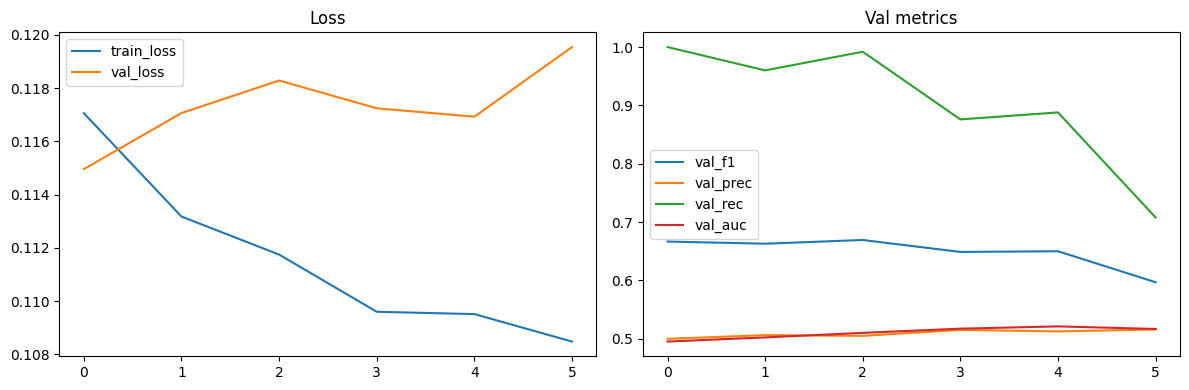

In [ ]:
model, history = train_model(model, train_loader, val_loader)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'],   label='val_loss')
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history['val_f1'],   label='val_f1')
plt.plot(history['val_prec'], label='val_prec')
plt.plot(history['val_rec'],  label='val_rec')
plt.plot(history['val_auc'],  label='val_auc')
plt.legend(); plt.title("Val metrics")
plt.tight_layout()
plt.show()


In [ ]:
# re-run validation to collect probs & labels
model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        imgs = batch['image'].to(device)
        txts = batch['text']
        labs = batch['label'].to(device)
        out  = model(imgs, texts=txts)
        all_probs.extend(torch.sigmoid(out['hate_logits']).cpu().numpy().tolist())
        all_labels.extend(labs.cpu().numpy().tolist())

prec, rec, thr = precision_recall_curve(all_labels, all_probs)
f1s = 2*prec*rec/(prec+rec+1e-8)
best = np.argmax(f1s)
print(f"Best dev F1={f1s[best]:.3f} at threshold {thr[best]:.2f}")


Best dev F1=0.667 at threshold 0.52
